In [57]:
import os
from typing import *

from dotenv import load_dotenv
load_dotenv()
from IPython.display import Image, display
import sqlite3


from langchain_ollama import ChatOllama
from langchain_together import ChatTogether
from langchain_huggingface import HuggingFaceEndpoint,ChatHuggingFace
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage, SystemMessage, ToolMessage, RemoveMessage
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.checkpoint.memory import MemorySaver
from langgraph.errors import NodeInterrupt

In [58]:
# ------------------------------------------------------ #
# GLOBALS
# ------------------------------------------------------ #
TOGETHER_API_KEY = os.getenv("TOGETHER_API_KEY")
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

In [59]:
# ------------------------------------------------------ #
# TOOLS
# ------------------------------------------------------ #
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

In [60]:
# ------------------------------------------------------ #
# MODELS
# ------------------------------------------------------ #
# chat_llm = ChatTogether(model="meta-llama/Llama-3.3-70B-Instruct-Turbo-Free", api_key=TOGETHER_API_KEY)
chat_llm = ChatOllama(model='llama3.2:latest')
tools = [add, multiply, divide]
llm_with_tools = chat_llm.bind_tools(tools)

In [61]:
# llm_with_tools.invoke('what is 2 plus 2')

In [62]:
# ------------------------------------------------------ #
# STATE
# ------------------------------------------------------ #
class State(MessagesState):
    summary: str

In [88]:
# ------------------------------------------------------ #
# NODES
# ------------------------------------------------------ #
from langgraph.errors import NodeInterrupt

def human_feedback(state: State):
    if len(state['messages'][-1].content) == 0:
        raise NodeInterrupt('Please, provide the question')
    return state


def assistant(state: State):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

In [89]:
# ------------------------------------------------------ #
# CONDITIONAL EDGES
# ------------------------------------------------------ #

In [90]:
# ------------------------------------------------------ #
# MEMORY
# ------------------------------------------------------ #
memory = MemorySaver()

In [91]:
# ------------------------------------------------------ #
# WORKFLOWS
# ------------------------------------------------------ #
def workflow_hil():
    # define workflow
    i_workflow = StateGraph(State)
    # nodes
    i_workflow.add_node('assistant', assistant)
    i_workflow.add_node('tools', ToolNode(tools))
    i_workflow.add_node('human_feedback', human_feedback)
    # edges
    i_workflow.add_edge(START, 'human_feedback')
    i_workflow.add_edge('human_feedback', 'assistant')
    i_workflow.add_conditional_edges('assistant', tools_condition)
    i_workflow.add_edge('tools', 'human_feedback')
    return i_workflow

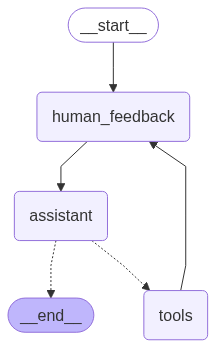

In [92]:
# ------------------------------------------------------ #
# COMPILE GRAPH
# ------------------------------------------------------ #
workflow = workflow_hil()
graph = workflow.compile(checkpointer=memory)
# graph = workflow.compile()
# print(graph.get_graph().draw_ascii())
display(Image(graph.get_graph().draw_mermaid_png()))

In [93]:
# Input
initial_input = {"messages": ""}

# Thread
thread = {"configurable": {"thread_id": "5"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================




In [86]:
for event in graph.stream(None, thread, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================




In [95]:
state = graph.get_state(thread)
print(state.next)
print(state.interrupts[0].value)

('human_feedback',)
Please, provide the question


In [81]:
graph.update_state(
    thread,
    {"messages": HumanMessage(content='And 9 by 8')},
)
# graph.update_state(thread, {'messages': HumanMessage(content='No, actually multiply 345 and 123')})

{'configurable': {'thread_id': '5',
  'checkpoint_ns': '',
  'checkpoint_id': '1f04b609-8753-6286-8007-26393c38799d'}}

In [82]:
state = graph.get_state(thread)

In [83]:
for event in graph.stream(None, thread, stream_mode="values"):
    if "messages" in event:

        event["messages"][-1].pretty_print()

================================ Human Message =================================

And 9 by 8


In [84]:
state = graph.get_state(thread)
state.next

()